# Attention Mechanisms과 Self Attention
---

## 1.1 Attention Mechanism

### 1.1.1 Intuitions

**시계열 데이터**

<img src = "../src/images/transformer-self-attention-01.png" width=900 height=900>

- 시계열 데이터는 $\mathbf{x}$은 noisy한 특성을 갖고 있음.
- 시계열 데이터 내의 노이즈를 해소하기 위해 re-weighing을 함.
    - re-weighing방법은 시점 $i$의 값을 단순히 시점 $i$로 표현하는 것이 아닌 시점 $i$와 가까운 값들로 표현해보자.
    - 가중치 벡터를 위와 같이 정의할 수 있음.(e.g. 시점 $i$에 평균값을 값는 정규분포에서 추출한 값들.) $\mathbf{w_i}= [w_{0i}, \cdots, w_{ni}]/$
- 새로운 값 $y_i = w_i^TX$은 기존의 값$\mathbf{x}$과 어떤 가중치 $\mathbf{w_i}$의 내적으로 표현.
    - $y_i$는 시점 $i$뿐만 아니라 context에 대한 정보를 함께 갖고 있는 값으로 표현됨.

**텍스트 데이터**

<img src = "../src/images/transformer-self-attention-02.png" width=900 height=900>

- $t_i$는 토큰
- $v_i$는 임베딩
- $w_i$는 임베딩으로 표현되는 가중치
- $y_i$는 가중치 * 임베딩으로 변환된 값.
- 텍스트의 경우 시계열처럼 **단순히 가까우면 가까울수록 높게 가중치를 주는 것**(sample from normal distribution)으로 생각하기는 어려움.
    - 텍스트의 경우 언어학적 관계가 실제 가중치에 학습이 되도록 고민하는 것이 중요. *(HOW???)*


> 우리가 워드 임베딩에서 내적을 통해 의미적 유사성(proximity)을 벡터에 학습시켰던 아이디어를 다시 생각해보자.

### 1.1.2 Idea of attention in text

- 간단히 vocab_size = 5인 상황을 생각해보자.

In [9]:
idx2token = ['bank', 'money', 'of', 'river', 'the']
token2idx = {token:i for i, token in enumerate(id2token)}
print(token2idx)

{'bank': 0, 'money': 1, 'of': 2, 'river': 3, 'the': 4}


- 각 토큰($t_i$)에 대한 임베딩($v_i$)을 초기화한다.
    - embedding size는 2로 가정하자.

In [12]:
import torch
from transformers import set_seed

# set_seed and random init
set_seed(42)
V = torch.randn(size=(len(idx2token),2))

print(V)

tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863],
        [ 2.2082, -0.6380],
        [ 0.4617,  0.2674]])


- Random initialize된 값을 통해 2차원 공간에 시각화.
    - 원점으로부터의 각도로 생각을 하자.(cosine similarity)
    - 여기서 money와 bank의 거리가 가까운 것은 우연임.

In [58]:
import pandas as pd
pd.options.plotting.backend = 'plotly' # https://towardsdatascience.com/plotting-in-pandas-just-got-prettier-289d0e0fe5c0

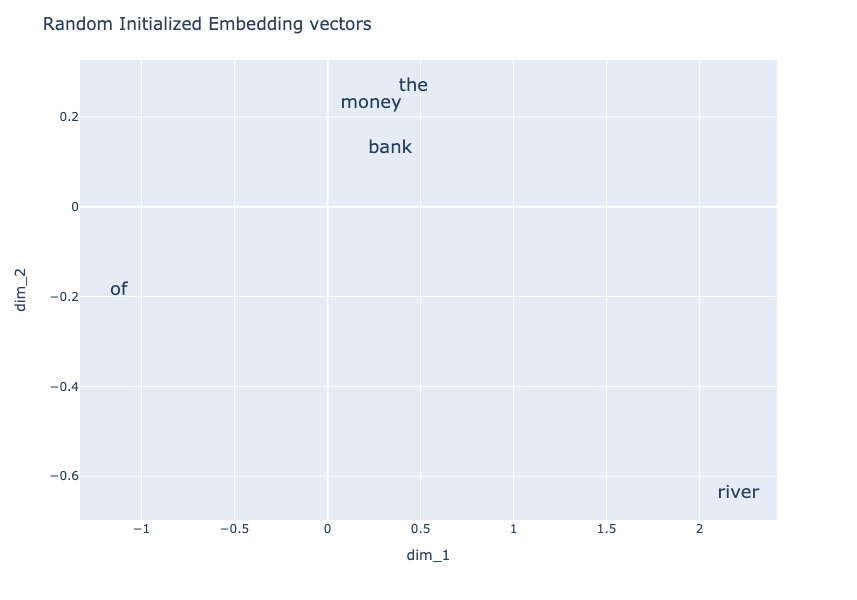

In [77]:
df = pd.DataFrame(V.numpy(), index=idx2token, columns=['dim_1', 'dim_2'])

# pandas plot.scatter
fig = df.plot.scatter(x='dim_1', y='dim_2', text=df.index, opacity=0)
# update layout
fig = fig.update_layout(height=600, width=600, paper_bgcolor='#FFFFFF', title= 'Random Initialized Embedding vectors', showlegend=False)
# update font features
fig = fig.update_traces(textfont=dict(size=18))
fig.show()

- 실제 데이터를 통해서 가중치를 구해보자. $W$

In [107]:
## preprocess sample data
# tokenize
tokens_list = 'the bank of river'.split()
# transform
ids_list = [token2idx[x] for x in tokens_list]
# indexing
input_tensor = torch.LongTensor(ids_list)
print(input_tensor)

tensor([4, 0, 2, 3])


$softmax(VV^T)$
- 각 토큰 별 임베딩에 대하여 내적을 계산한 후 softmax를 계산함.
- 이 과정을 통해 토큰 간의 가중치를 유사성 개념을 추가하여 계산을 할 수 있음.

In [109]:
embedding = V[input_tensor]
W = embedding @ embedding.T
pd.DataFrame(W.numpy(), index=tokens_list, columns=tokens_list)

,the,bank,of,river
the,0.284604,0.189873,-0.568190,0.848863
bank,0.189873,0.129952,-0.402056,0.661300
of,-0.568190,-0.402056,1.295525,-2.360616
river,0.848863,0.661300,-2.360616,5.283194


- 각 토큰의 임베딩에 대하여 다음과 같이 가중치와 원래 임베딩의 가중합을 통해 새로운 임베딩으로 변환할 수 있다.
    - 이 때, 새로운 토큰 $y_i$에는 $v_i$뿐만 아니라 문장 내 다른 토큰에 대한 임베딩($\cdots v_{i-1}$, $v_{i+1} \cdots$)들이 고려되어 컨텍스트의 의미를 explicit하게 새로운 토큰에 부여할 수 있음.
$$y_i = \sum_{k=0}^{3} w_{ik} v_k$$

In [130]:
y_embedding = W @ embedding
df = pd.DataFrame(y_embedding.numpy(), index=tokens_list, columns=['dim_1', 'dim_2'])
df = pd.concat((df, pd.DataFrame(data=V[1].numpy().reshape(1,2),index=[id2token[1]], columns=['dim_1', 'dim_2']))) # add money

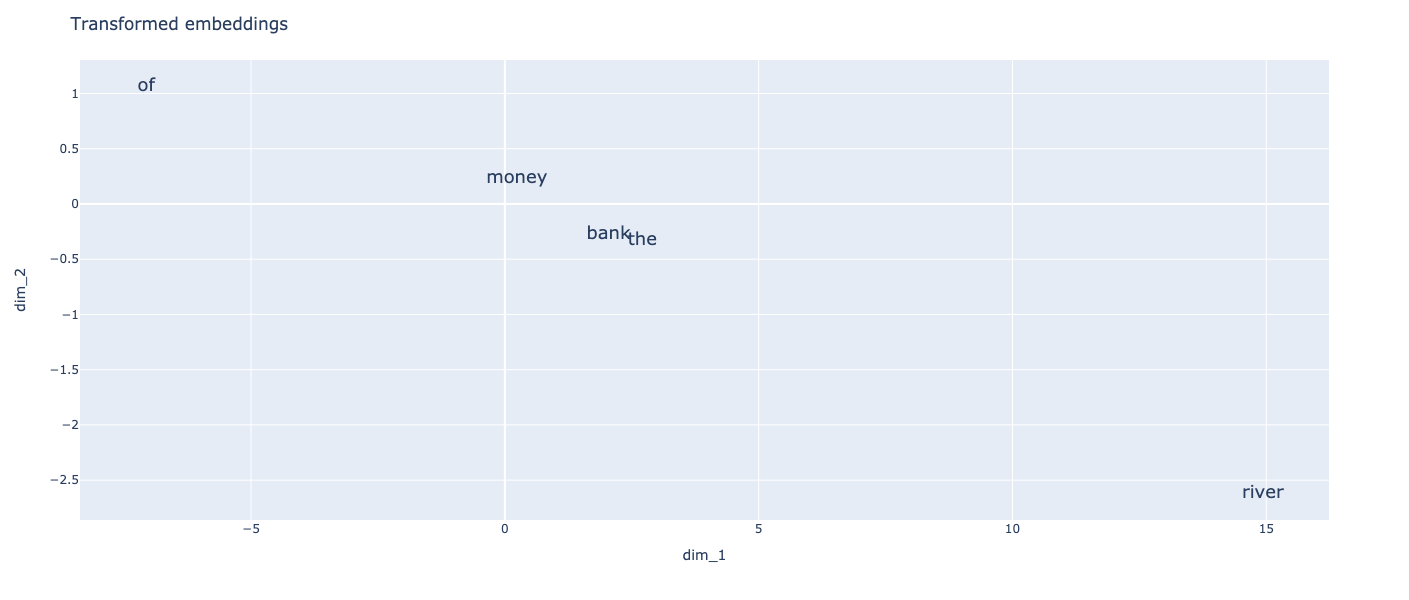

In [131]:
# pandas plot.scatter
fig = df.plot.scatter(x='dim_1', y='dim_2', text=df.index, opacity=0)
# update layout
fig = fig.update_layout(height=600, width=600, paper_bgcolor='#FFFFFF', title= 'Transformed embeddings', showlegend=False)
# update font features
fig = fig.update_traces(textfont=dict(size=18))
fig.show()

- `of`와 `river`가 다른 토큰들과 cosine similarity가 높아짐. (한 직선위에 있음)
> 즉, 한 문장내에 등장하는 토큰 간의 유사성이 explicit하게 계산되도록 조정해줌.

## 1.2 Self Attention : Keys, Values, Queries

앞서 살펴본 예제는 attention mechanism 중 하나인 self-attention mechanism에 대한 연산을 진행한 것이다.

그러면 이제 attention mechanism의 중심 개념인 key, value query에 대하여 살펴보자.

### 1.2.1 keys, values, queries

1.1.2 에서 계산한 예제를 도식화 해보면 아래와 같이 그릴 수 있다. (위 예제에서는 normalize step이 없음.)


<img src= "../src/images/transformer-self-attention-03.png" width=900 height=900>

**queries**
- attention layer의 input임.
- 위 예제에서 하나의 token에 대한 임베딩.

**keys**
- 위 예제에서 각 token에 대한 

**values**
- 위 예제에서 각 query와 key로 구해진 weight와 곱해지는 값들.

> 위 예제의 경우 다 constant여서 실제 모델 학습과정에서 값이 달라지는 것은 없다. 하지만, 만약 key, query, value 각각이 **trainable한 weight**라면 학습을 통해 context와 관련된 어떠한 패턴을 학습할 수 있지 않을까??? 

### 1.2.2 self attention layer

<img src="../src/images/transformer-self-attention-04.png" width=900 height=900>

- keys, queries, values에 대한 weight을 학습할 수 있는 matrix가 존재함.
- 원래는 token, keys, queries, values의 총 네 개의 matrix가 필요하지만, 그냥 key, query, value에 대한 embedding 즉 행렬 세개로 가져가는 것이 결과적으로 똑같지만 메모리상 이득을 취할 수 있음.

## 1.3 Multi-head attention

- self attention이 단일 문장 내의 context를 잘 학습할 수 있다는 장점이 있지만, 문장 내에 있는 여러가지 언어학적 관계를 하나의 attention값으로 다 담기 어려움.
- 그래서 attention head를 여러개 가져가자.